# Data Acquisition

In this notebook, we download and process the data so that in a next step we are able to work on it.
Processing in at this point includes:
- projection/clipping to equal AOI
- time matching
- resolution equalization (could be moved to [02_TroMoM](02_TroMoM.ipynb)
- creation of reasonable file structure for processed data
- (format conversion)


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

from shapely.geometry.polygon import orient

- Define an area of interest (AOI) by specifying an input geoJSON/shapefile.
- Define a time interval of interest.

In [33]:
AOI_file = "./misc/malaysia_single.geojson" # alternatively coordinates: # Example over the state of Colorado: -109,37,-102,41
time = ["2022-01-01", "2023-04-30"]

credentials_smap = {
    "mail": "colin.moldenhauer@tum.de",
    "user": "TroMoM",
    "pwd": "jWrfPSxNh54DTZX"
}

visualize AOI:

(90.52953402297753, 128.37035433749065)

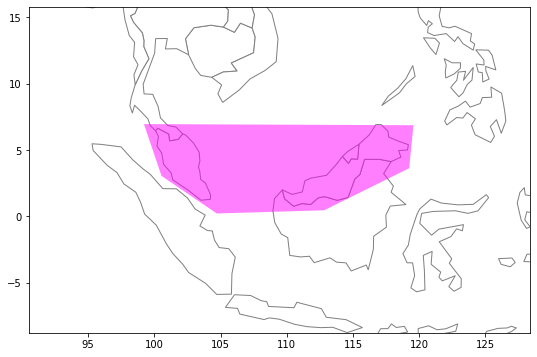

In [34]:
# Use geopandas to read in polygon file
AOI = gpd.read_file(AOI_file)

# CMR polygon points need to be provided in counter-clockwise order. The last point should match the first point to close the polygon.

# Simplify polygon for complex shapes in order to pass a reasonable request length to CMR. The larger the tolerance value, the more simplified the polygon.
# Orient counter-clockwise: CMR polygon points need to be provided in counter-clockwise order. The last point should match the first point to close the polygon.

poly = orient(AOI.simplify(0.05, preserve_topology=False).loc[0],sign=1.0)

geojson = gpd.GeoSeries(poly).to_json() # Convert to geojson
geojson = geojson.replace(' ', '') #remove spaces for API call

#Format dictionary to polygon coordinate pairs for CMR polygon filtering
polygon = ','.join([str(c) for xy in zip(*poly.exterior.coords.xy) for c in xy])

# create buffer for plot bounds
crs_before = AOI.crs
crs_utm = AOI.estimate_utm_crs()
buffer = AOI.to_crs(crs_utm).buffer(1e6).to_crs(crs_before)
envelope = buffer.envelope
bounds = envelope.bounds

# Plot
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
f, ax = plt.subplots(1, figsize=(12, 6))
world.plot(ax=ax, facecolor='white', edgecolor='gray')
AOI.plot(ax=ax, cmap='spring', alpha=.5)
ax.set_ylim([bounds.miny[0], bounds.maxy[0]])
ax.set_xlim([bounds.minx[0], bounds.maxx[0]])

### SMAP
Download of soil moisture data

In [53]:
import requests
import json

def download_smap(aoi, time, short_name="SPL2SMA"):
    cmr_collections_url = 'https://cmr.earthdata.nasa.gov/search/collections.json'

    # temporal = start_date + 'T' + start_time + 'Z' + ',' + end_date + 'T' + end_time + 'Z'
    temporal = f"{time[0]}T00:00:00Z,{time[1]}T00:00:00Z"
    print("temporal:", temporal)

    response = requests.get(cmr_collections_url, params={"short_name": short_name})
    results = json.loads(response.content)
    print("results", results)
    versions = [el['version_id'] for el in results['feed']['entry']]
    latest_version = max(versions)
    print('The most recent version of ', short_name, ' is ', latest_version)

    if isinstance(aoi, str):
        search_params = {
            'short_name': short_name,
            # 'version': latest_version,
            # 'temporal': temporal,
            'page_size': 100,
            'page_num': 1,
            'polygon': aoi,
        }
    else:
        search_params = {
            'short_name': short_name,
            # 'version': latest_version,
            # 'temporal': temporal,
            'page_size': 100,
            'page_num': 1,
            'bounding_box': aoi
        }

    granules = []
    headers={'Accept': 'application/json'}
    while True:
        response = requests.get(cmr_collections_url, params=search_params, headers=headers)
        results = json.loads(response.content)
        # print("response")
        # print(response)
        # print()
        # print("results")
        # print(results)

        if len(results['feed']['entry']) == 0: break

        granules.extend(results['feed']['entry'])
        # print("available keys", results["feed"]["entry"][0].keys())
        search_params['page_num'] += 1


    # print('There are', len(granules), 'granules of', short_name, 'over my area and time of interest.')
    # granule_sizes = [float(granule['granule_size']) for granule in granules]
    #
    # print(f'The average size of each granule is {np.mean(granule_sizes):.2f} MB and the total size of all {len(granules)} granules is {sum(granule_sizes):.2f} MB')




download_smap(polygon, time)
# download_smap("-109,37,-102,41", time)

temporal: 2022-01-01T00:00:00Z,2023-04-30T00:00:00Z
results {'feed': {'updated': '2023-05-17T08:28:15.844Z', 'id': 'https://cmr.earthdata.nasa.gov:443/search/collections.json?short_name=SPL2SMA', 'title': 'ECHO dataset metadata', 'entry': [{'processing_level_id': 'Level 2', 'cloud_hosted': False, 'boxes': ['-85.044 -180 85.044 180'], 'time_start': '2015-04-13T00:00:00.000Z', 'version_id': '003', 'dataset_id': 'SMAP L2 Radar Half-Orbit 3 km EASE-Grid Soil Moisture V003', 'has_spatial_subsetting': True, 'has_transforms': True, 'associations': {'services': ['S1568899363-NSIDC_ECS', 'S2011082551-NSIDC_ECS', 'S1977894169-NSIDC_ECS', 'S1956579962-NSIDC_ECS'], 'tools': ['TL1952642907-NSIDC_ECS', 'TL2000645101-NSIDC_ECS', 'TL1977971361-NSIDC_ECS', 'TL2013523138-NSIDC_ECS', 'TL2012682515-NSIDC_ECS', 'TL2011654705-NSIDC_ECS']}, 'has_variables': True, 'data_center': 'NSIDC_ECS', 'short_name': 'SPL2SMA', 'organizations': ['NASA NSIDC DAAC', 'NASA/JPL/SMAP'], 'title': 'SMAP L2 Radar Half-Orbit 3 km

KeyError: 'granule_size'

In [ ]:
def download_ndvi(aoi, time): pass